In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

/Users/tatenda/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Cleaning metadata
# In[147]:
metadata=pd.read_csv("movie_metadata_with_score_metacritic.csv", index_col="Unnamed: 0") #reading in metacritic dataset

In [3]:
metadata=metadata.loc[~metadata["metacritic_metascore"].isna()] #removing rows with no metacritic data


In [4]:
metadata=metadata.drop(["homepage","keywords","overview","status","tagline","imdb_metascore"],1) #dropping unnecessary features

In [5]:
metadata=metadata.drop_duplicates() #dropping duplicates
metadata["release_year"]=metadata.release_date.str[0:4].astype(int) #creating new column with year for comparison

In [6]:
# In[131]:

rev_data=pd.read_csv("Revenue.csv") #reading in revenue data
#cleaning revenue data
#Adjusting units
rev_data["Budget"]=rev_data["Budget($M)"]*1000000
rev_data["Worldwide Gross"]=rev_data["Worldwide Gross($M)"]*1000000
rev_data["Domestic Gross"]=rev_data["Domestic Gross($M)"]*1000000
rev_data=rev_data.drop(["Budget($M)","Domestic Gross($M)","Worldwide Gross($M)"],1)

rev_data=rev_data.rename(columns={"Movie":"title"})#renaming column to match metadata
rev_data=rev_data.drop_duplicates()#dropping duplicates

In [7]:
# In[102]:


critic_revenue=metadata.merge(rev_data,on="title") #merging datasets
critic_revenue=critic_revenue.drop_duplicates() #dropping duplicates
critic_revenue=critic_revenue.loc[(critic_revenue["Worldwide Gross"]!=0) | (critic_revenue["revenue"]!=0)] #removing rows with no revenue data
critic_revenue=critic_revenue.loc[(np.abs(critic_revenue.release_year-critic_revenue.Year)<=5)] #removing rows where the years don't match, as this indicates different movies

#Normalizing by the median for merged data set

critic_revenue["budget"]=(metadata["budget"]-metadata["budget"].median())/metadata["budget"].std()
critic_revenue["Worldwide Gross"]=(rev_data["Worldwide Gross"]-rev_data["Worldwide Gross"].median())/rev_data["Worldwide Gross"].std()

critic_revenue["Domestic Gross"]=(rev_data["Domestic Gross"]-rev_data["Domestic Gross"].median())/rev_data["Domestic Gross"].std()
critic_revenue["popularity"]=(metadata["popularity"]-metadata["popularity"].median())/metadata["popularity"].std()
critic_revenue["revenue"]=(metadata["revenue"]-metadata["revenue"].median())/metadata["revenue"].std()
critic_revenue["vote_count"]=(metadata["vote_count"]-metadata["vote_count"].median())/metadata["vote_count"].std()

In [9]:
critic_revenue_small=critic_revenue.loc[critic_revenue['Budget'] <= 40000000]
critic_revenue_small.shape[0]

2381

In [10]:
critic_revenue_small.head()

,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,...,vote_average,vote_count,metacritic_metascore,release_year,Month,Day,Year,Budget,Worldwide Gross,Domestic Gross
71,2.954415,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",79698,en,The Lovers,1.349131,"[{""name"": ""Corsan"", ""id"": 7299}, {""name"": ""Bli...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",2015-02-13,2.137175,...,4.8,0.805525,19.0,2015,Mar,13,2015,35000000.0,4.394735,3.387908
84,3.663475,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",9799,en,The Fast and the Furious,0.783667,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",2001-06-22,0.682528,...,6.6,0.758683,58.0,2001,Jun,22,2001,38000000.0,4.162857,3.229438
277,3.072592,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...",29193,en,The Spanish Prisoner,2.245207,"[{""name"": ""Jean Doumanian Productions"", ""id"": ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-09-08,3.288009,...,7.1,2.700697,70.0,1997,Apr,3,1998,10000000.0,1.993153,1.778817
336,1.654472,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",9387,en,Conan the Barbarian,0.152416,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1982-04-02,0.751591,...,6.6,0.179688,43.0,1982,May,14,1982,20000000.0,1.828499,1.679839
370,1.654472,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 35, ""nam...",16281,en,Creepshow,1.085636,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1982-11-12,1.752082,...,6.7,2.224600,59.0,1982,Nov,10,1982,8000000.0,1.708312,1.195991


In [11]:
critic_revenue_small.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,metacritic_metascore,release_year,Day,Year,Budget,Worldwide Gross,Domestic Gross
count,1936.000000,2381.000000,1936.000000,1936.000000,2381.000000,2381.000000,1936.000000,2381.000000,2381.000000,2381.000000,2381.000000,2.381000e+03,2322.000000,2322.000000
mean,0.049178,48928.091978,0.140630,0.159146,105.520370,6.227131,0.210245,55.006300,2002.572869,15.971861,2002.725325,1.569960e+07,0.172750,0.238387
std,0.393133,78932.336312,0.576975,0.474960,19.011167,0.940733,0.655940,18.993242,11.075346,8.618797,11.122057,1.177950e+07,0.258521,0.362214
min,-0.472706,14.000000,-0.510113,-0.195277,0.000000,0.000000,-0.258014,1.000000,1934.000000,1.000000,1934.000000,7.000000e+03,-0.090100,-0.272867
25%,-0.212718,8998.000000,-0.267586,-0.166578,94.000000,5.700000,-0.170473,41.000000,1999.000000,9.000000,1999.000000,5.000000e+06,-0.013944,-0.017851
50%,0.000000,13967.000000,-0.026419,-0.002745,102.000000,6.300000,-0.023805,55.000000,2005.000000,16.000000,2005.000000,1.400000e+07,0.101642,0.168760
75%,0.283624,46261.000000,0.377884,0.296743,114.000000,6.800000,0.315030,69.000000,2010.000000,23.000000,2010.000000,2.500000e+07,0.303524,0.432518
max,3.663475,385736.000000,3.994802,3.716905,338.000000,9.300000,6.212293,100.000000,2016.000000,31.000000,2017.000000,4.000000e+07,4.394735,3.387908


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import train_test_split # to split the data into two parts

In [14]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

In [15]:
critic_revenue_small.isnull().any()

budget                   True
genres                  False
id                      False
original_language       False
original_title          False
popularity               True
production_companies    False
production_countries    False
release_date            False
revenue                  True
runtime                 False
spoken_languages        False
title                   False
vote_average            False
vote_count               True
metacritic_metascore    False
release_year            False
Month                   False
Day                     False
Year                    False
Budget                  False
Worldwide Gross          True
Domestic Gross           True
dtype: bool

In [16]:
#Replace every nan values with 0
critic_revenue_small.fillna(value=0,axis=1,inplace=True)
critic_revenue_small.shape

/Users/tatenda/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


(2381, 23)

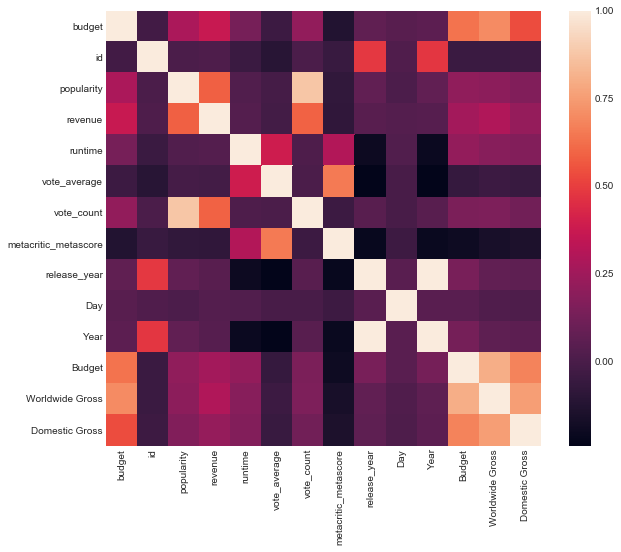

In [17]:
sns.heatmap(critic_revenue_small.corr(), vmax=1, square=True)

In [18]:
#Defining features and target for this dataset based on co-relation
features = ['Budget']
target = ['Worldwide Gross']

In [19]:
#splitting data set into training and test data set in 0.7/0.3
train, test = train_test_split(critic_revenue_small,test_size=0.30)
train.head()

,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,...,vote_average,vote_count,metacritic_metascore,release_year,Month,Day,Year,Budget,Worldwide Gross,Domestic Gross
981,0.472706,"[{""id"": 35, ""name"": ""Comedy""}]",225886,en,Sex Tape,-0.326061,"[{""name"": ""Escape Artists"", ""id"": 1423}, {""nam...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2014-07-17,-0.195277,...,5.3,-0.167402,36.0,2014,Jul,18,2014,40000000.0,0.676737,1.900787
2806,0.000000,"[{""id"": 27, ""name"": ""Horror""}]",16337,en,The Texas Chainsaw Massacre 2,0.000000,"[{""name"": ""Cannon Films"", ""id"": 4110}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1986-08-22,0.000000,...,5.9,0.000000,42.0,1986,Aug,22,1986,4700000.0,-0.024600,0.100971
3179,-0.472706,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 18, ""...",3170,en,Bambi,-0.477549,"[{""name"": ""Walt Disney Productions"", ""id"": 3166}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1942-08-14,-0.159654,...,6.8,-0.247263,91.0,1942,Aug,13,1942,858000.0,-0.073304,-0.017926
2376,-0.472706,"[{""id"": 28, ""name"": ""Action""}, {""id"": 27, ""nam...",9362,en,Tremors,-0.234886,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1990-01-19,-0.195277,...,6.6,-0.145133,65.0,1990,Jan,19,1990,10000000.0,0.000000,0.000000
2670,-0.472706,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 53, ""nam...",11361,en,Halloween 5: The Revenge of Michael Myers,-0.379227,"[{""name"": ""Trans Pacific Films"", ""id"": 4351}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1989-10-12,-0.195277,...,5.2,-0.251870,28.0,1989,Oct,13,1989,6000000.0,-0.002512,0.042126


In [20]:
#Fill the training and test data with require information
X_train = train[features].dropna()
y_train = train[target].dropna()
X_test = test[features].dropna()
y_test = test[target].dropna()

In [21]:
from sklearn import linear_model# compute classification accuracy for the linear regression model
from sklearn import metrics # for the check the error and accuracy of the model
lin = linear_model.LinearRegression()
# train the model on the training set
lin.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
lin_score_train = lin.score(X_test, y_test)
lin_score_test = lin.score(X_train, y_train)

In [23]:
print("Training score: ",lin_score_train)
print("Testing score: ",lin_score_test)

Training score:  0.7960498991830306
Testing score:  0.6060314797783849


In [24]:
yPrediction = lin.predict(X_test)

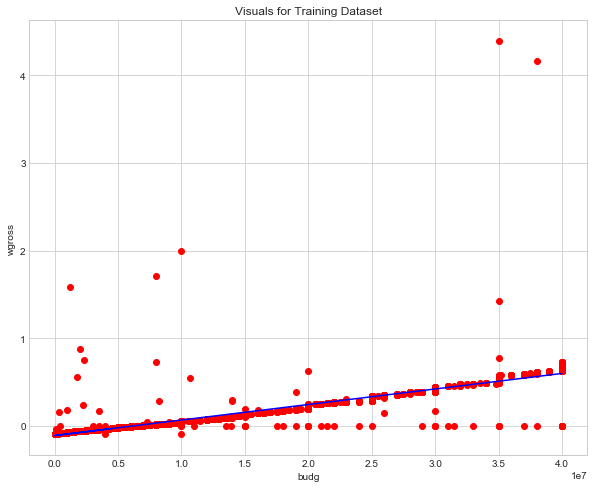

In [25]:
# Visualising the training set results
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, lin.predict(X_train), color = 'blue')
plt.title ("Visuals for Training Dataset")
plt.xlabel("budg")
plt.ylabel("wgross")
plt.show()

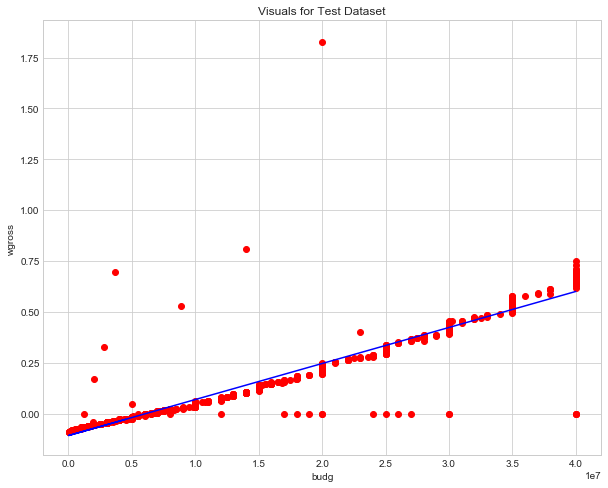

In [26]:
plt.scatter(X_test, y_test , color = 'red')
plt.plot(X_train, lin.predict(X_train), color = 'blue')
plt.title ("Visuals for Test Dataset")
plt.xlabel("budg")
plt.ylabel("wgross")
plt.show()

In [27]:
from sklearn import neighbors
n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [28]:
knn_score_train = knn.score(X_test, y_test)
knn_score_test = knn.score(X_train, y_train)

print("Training score: ",knn_score_train)
print("Testing score: ",knn_score_test)

Training score:  0.7670560433638135
Testing score:  0.6150912404185321
